# Loading data

In [50]:
%reload_ext autoreload
%autoreload 2
import pandas as pd
import psycopg2
from tqdm.cli import tqdm
import janitor

import matplotlib.pyplot as plt
#plt.rcParams['figure.figsize'] = (20, 10)
plt.rc('figure', figsize=(10,6), facecolor='white')
#plt.rcParams['axes.facecolor'] = 'white'

# tenant_reviews
TABLES_NAMES = ['tenant_reviews_clean','visits_contracts','visits_offers_contracts']

In [51]:
def load_tables_sql(tables_names = TABLES_NAMES):
    print("loading tables from sql")
    conn = psycopg2.connect(
        dbname="quintoandar",
        host="db.candidates.sandbox.data.quintoandar.com.br",
        port="5432",
        user="data-analytics",
        password="97PGf56yWCWa",
        client_encoding='UTF8'
    )
    query = "select * from {}"

    tables = {}
    try:
        for table in tqdm(tables_names):
            df = pd.read_sql(query.format(table), con=conn)
            tables[table] = df
            print(table, df.shape)
    finally:
        conn.close()
    
    return tables


def load_tables_parquet(tables = TABLES_NAMES):
    print("loading tables from parquet")
    parquet_tables = {}
    for table in tables:
        df = pd.read_parquet(f'data/{table}.parquet')
        parquet_tables[table] = df
        print(table, df.shape)
        #print(f"{table}:shape of differences: {df.compare(df2).shape}")

    return parquet_tables


load_sql = False

if load_sql:
    tables = load_tables_sql()
    # for table, df in tables.items():
    #     df.to_parquet(f'data/{table}.parquet')
else:
    tables = load_tables_parquet()

loading tables from parquet
tenant_reviews_clean (13470, 18)
visits_contracts (15, 3)
visits_offers_contracts (8, 7)


In [52]:
#dftenant_reviews = tables['tenant_reviews']
dftenant_reviews_raw = tables['tenant_reviews_clean']
dfvisits_contracts = tables['visits_contracts']
dfvisits_offers_contracts_raw = tables['visits_offers_contracts']

# Tratamentos

In [53]:
# data treatments
dftenant_reviews = dftenant_reviews_raw.copy()

dftenant_reviews["visit_date"] = pd.to_datetime(dftenant_reviews["visit_date"])

dftenant_reviews['total'] = True

# order review categories
review_dtype = pd.CategoricalDtype(
    ["Visita não aconteceu.", "1", "2", "3", "4", "5", "VaiNegociar"], ordered=True
)
dftenant_reviews["review"] = dftenant_reviews["review"].replace(
    "EntradaNaoAutorizada", "Visita não aconteceu."
).astype(review_dtype)

# review dummies
dftenant_reviews = pd.concat(
    [dftenant_reviews, pd.get_dummies(dftenant_reviews["review"], prefix="review")],
    axis=1,
)

dftenant_reviews['visit_date_ym'] = dftenant_reviews['visit_date'].dt.strftime('%b')

#dftenant_reviews.columns

In [54]:
# grouping columns

flags = [
    "building",
    "conservation",
    "size",
    "price",
    "location",
    "total",
]


neg_flags = [
    
    "did_not_like_the_location",
    "expected_a_better_preserved_property",
    "bigger_in_photos",
    "different_from_the_listing",
    "total",
]

others = [
    # "visit_date",
    # "day",
    # "time",
    # "house_id",
    # "neighbourhood",
    # "visitor",
    # "agent",
    # "review",
    # "others",
]

dummies = list(dftenant_reviews.columns[dftenant_reviews.columns.str.startswith("review_")])


cols_other = [c for c in dftenant_reviews.columns if c not in flags+neg_flags+dummies]


#dftenant_reviews.groupby(flags)[['visitor']].count().sort_values(flags)

def fmtr(args):
    x,y=args
    return f"{x:.0f} ({y:.0%})"



In [55]:
# dfvisits_offers_contracts
months_cat = ['jan', 'fev', 'mar', 'abr', 'mai', 'jun', 'jul', 'ago']
months_cat = pd.CategoricalDtype(months_cat, ordered=True)

funnel_cat = [
    "visits",
    "tenant_that_visited",
    "visited_houses",
    "offers",
    "tenants_that_made_offers",
    "contracts",
]
funnel_cat = pd.CategoricalDtype(reversed(funnel_cat), ordered=True)

dfvisits_offers_contracts = pd.melt(dfvisits_offers_contracts_raw,id_vars=["month"])

dfvisits_offers_contracts['month'] = dfvisits_offers_contracts['month'].astype(months_cat)
dfvisits_offers_contracts['variable'] = dfvisits_offers_contracts['variable'].astype(funnel_cat)

In [56]:
## IMAGES
import os
if not os.path.exists("images"):
    os.mkdir("images")

# EDA

## Contratos de visitas

Para começar, vamos explorar a tabela de contratos de visitas.

O gráfico abaixo mostra que o número inquilinos que não assinaram cai (quase que) exponencialmente com o número de visitas. Enquanto que o número de inquilinos que assinaram também decresce, mas num  .

Se considerarmos a proporção de inquilinos que assinaram como uma estimativa de probabilidade, então
**a probabilidade do inquilino assinar parece crescer com o número de visitas até a quinta vista e depois decrescer.**

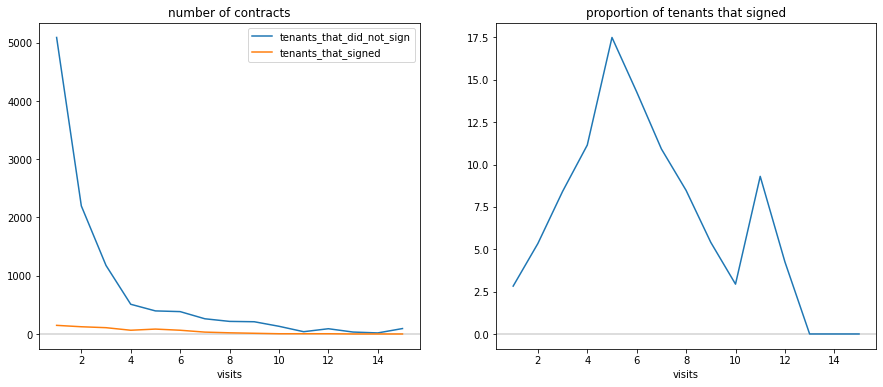

In [62]:
# dfvisits_contracts

fig, axs = plt.subplots(ncols=2, figsize=(15,6))

df = dfvisits_contracts.set_index('visits').copy()

df.plot(ax=axs[0], title='number of contracts')
axs[0].axhline(0, c='lightgray', zorder=-10)

df['prop_tenants_that_signed'] = df['tenants_that_signed'] / df.sum(axis=1) * 100
df['prop_tenants_that_signed'].plot(ax=axs[1], title='proportion of tenants that signed')
axs[1].axhline(0, c='lightgray', zorder=-10)

plt.savefig('images/fig01.png')

## Funil de contratos de ofertas de visitas

A figura mostra a tendências das variáveis ao longo do tempo e, no lado direito, as correlações (lineares) dessas variáveis entre si.

Como mencionado no case, o número de contratos apresenta uma tendência de queda. 

O número de inquilinos que visitaram e o número de visitas mostram-se *negativamente* correlacionadas com o número de contratos.
Enquanto que o número de inquilinos que fizeram uma oferta é *positivamente* correlacionado com o número de contratos.

O bottleneck que parece ser o mais grave acontece no número de casas visitadas. O **número de casas visitadas parece estar limitando o funil abaixo**: número de ofertas, de inquilinos que fizeram ofertas e, consequentemente, o número de contratos.

Um outro bottleneck parece ser o número de **inquilinos que fizeram ofertas**.


In [63]:
import plotly.express as px

fig = px.funnel(
    dfvisits_offers_contracts,
    x="value",
    y="variable",
    color="variable",
    color_discrete_sequence=px.colors.sequential.Viridis,
    category_orders={"variable": funnel_cat.categories},
    facet_col="month",
    facet_col_wrap=4,
    facet_row_spacing=0.1,
    title='Funnel through months',
    width=1000, height=600
)
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[1]))
fig.update_layout(legend={'traceorder': 'reversed'})

#fig.for_each_trace(lambda t: t.update(name=t.name.split("=")[1]))
#fig.show()

#from IPython.display import Image
#Image(fig.to_image())

fig.write_image('images/fig02.png')
fig


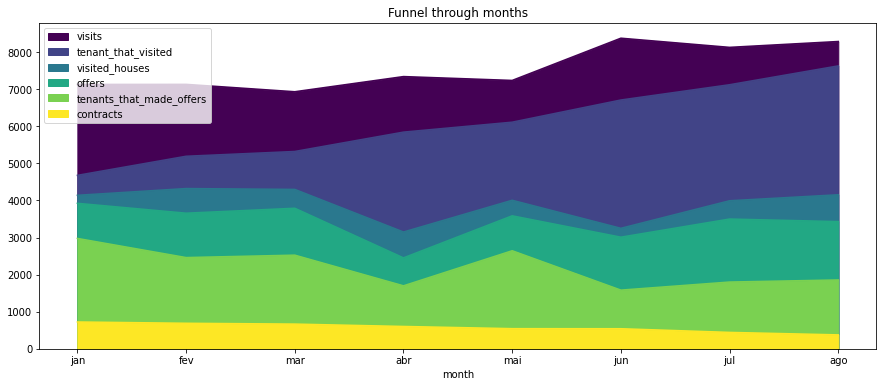

In [70]:
# dfvisits_offers_contracts
from plot_corr import plot_corr
fig, ax = plt.subplots(figsize=(15, 6))
# plot1
dfvisits_offers_contracts_raw.set_index('month').plot.area(ax=ax, title='Funnel through months', stacked=False, alpha=1, cmap='viridis')

plt.savefig('images/fig03.png')


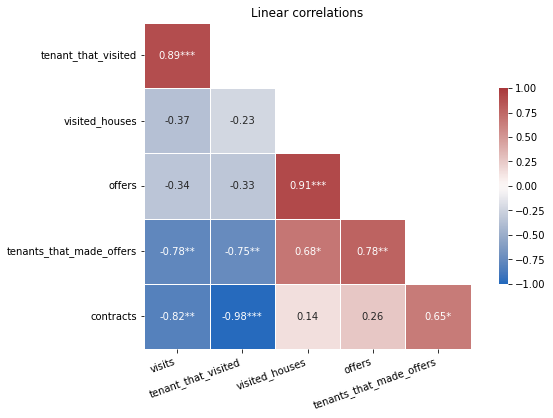

In [68]:
# dfvisits_offers_contracts
from plot_corr import plot_corr

fig, ax = plt.subplots()

plot_corr(dfvisits_offers_contracts_raw, ax=ax)
ax.set_title('Linear correlations')

plt.savefig('images/fig04.png')

## Review dos inquilinos

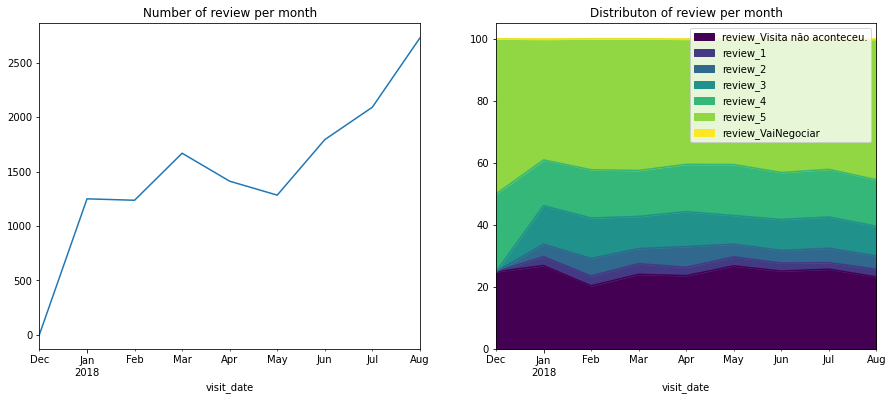

In [74]:
month = pd.Grouper(key='visit_date', freq='1M')

# dftenant_reviews
fig,axs=plt.subplots(ncols=2,figsize=(15,6))

#plot1
ax=axs[0]
dftenant_reviews.groupby(month)['total'].sum().plot(title="Number of reviews per month", ax=ax)
#dftenant_reviews.groupby(month).house_id.nunique().plot(label='unique houses', ax=ax)
#ax.legend()

#plot2
reviews_per_month = dftenant_reviews.groupby(month)[dummies+['total']]
(reviews_per_month.mean()* 100).iloc[:, :-1].plot.area(cmap='viridis', title='Distributon of reviews per month', ax=axs[1])

#display(reviews_per_month.agg(lambda x: (x.sum(),x.mean())).pipe(lambda x, fmt: x.set_index(x.index.strftime(fmt)), "%Y-%m").T.style.format(fmtr))

# tabela numero de reviews por mes por tipo de review
# (
#     dftenant_reviews.groupby(
#         [pd.Grouper(key="visit_date", freq="1M"), "review"], dropna=True
#     )["total"]
#     .count()
#     .unstack(1)
#     .rename_axis(columns="reviews por mes")
#     .pipe(lambda x: x.set_axis(x.index.strftime("%b"), axis=0))
# )

plt.savefig('images/fig05.png')

## Tenant's opinions

In [12]:
# positive opinions
flags_per_review = dftenant_reviews.groupby('review')[flags].agg(lambda x: (x.sum(),x.mean())).T
display(flags_per_review.rename_axis(index='positive opinions (liked the ...)').style.format(fmtr))

flags_per_review = dftenant_reviews.groupby('visit_date_ym', sort=False)[flags].agg(lambda x: (x.sum(),x.mean())).T
display(flags_per_review.rename_axis(index='positive opinions per month').style.format(fmtr))

review,Visita não aconteceu.,1,2,3,4,5,VaiNegociar
positive opinions (liked the ...),,,,,,,
building,0 (0%),0 (0%),0 (0%),0 (0%),0 (0%),2839 (50%),0 (0%)
conservation,0 (0%),0 (0%),0 (0%),0 (0%),0 (0%),3609 (64%),6 (20%)
size,0 (0%),0 (0%),0 (0%),0 (0%),0 (0%),3581 (63%),9 (30%)
price,0 (0%),0 (0%),0 (0%),0 (0%),0 (0%),2477 (44%),12 (40%)
location,0 (0%),0 (0%),0 (0%),0 (0%),0 (0%),4514 (80%),11 (37%)
total,3302 (100%),364 (100%),635 (100%),1416 (100%),2050 (100%),5673 (100%),30 (100%)


visit_date_ym,Dec,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug
positive opinions per month,,,,,,,,,
building,0 (0%),253 (20%),275 (22%),346 (21%),286 (20%),254 (20%),381 (21%),431 (21%),613 (22%)
conservation,0 (0%),300 (24%),335 (27%),449 (27%),356 (25%),339 (26%),487 (27%),553 (26%),796 (29%)
size,0 (0%),303 (24%),336 (27%),468 (28%),365 (26%),334 (26%),473 (26%),542 (26%),769 (28%)
price,1 (25%),225 (18%),224 (18%),307 (18%),244 (17%),227 (18%),316 (18%),382 (18%),563 (21%)
location,1 (25%),393 (31%),418 (34%),584 (35%),467 (33%),393 (31%),621 (35%),690 (33%),958 (35%)
total,4 (100%),1250 (100%),1237 (100%),1669 (100%),1412 (100%),1284 (100%),1794 (100%),2092 (100%),2728 (100%)


In [13]:
# negative opinions
#dftenant_reviews.groupby('review')[flags].apply(lambda x: x.sum().astype(str) + " (" + (x.mean()*100).round(0).astype(str)+"%)").T
neg_flags_per_review = dftenant_reviews.groupby('review')[neg_flags].agg(lambda x: (x.sum(),x.mean())).T
display(neg_flags_per_review.rename_axis(index='Negative opinions').style.format(fmtr))


review,Visita não aconteceu.,1,2,3,4,5,VaiNegociar
Negative opinions,,,,,,,
did_not_like_the_location,1 (0%),64 (18%),118 (19%),226 (16%),298 (15%),0 (0%),3 (10%)
expected_a_better_preserved_property,0 (0%),236 (65%),376 (59%),720 (51%),743 (36%),0 (0%),2 (7%)
bigger_in_photos,0 (0%),92 (25%),210 (33%),468 (33%),678 (33%),0 (0%),10 (33%)
different_from_the_listing,0 (0%),96 (26%),79 (12%),93 (7%),38 (2%),0 (0%),2 (7%)
total,3302 (100%),364 (100%),635 (100%),1416 (100%),2050 (100%),5673 (100%),30 (100%)


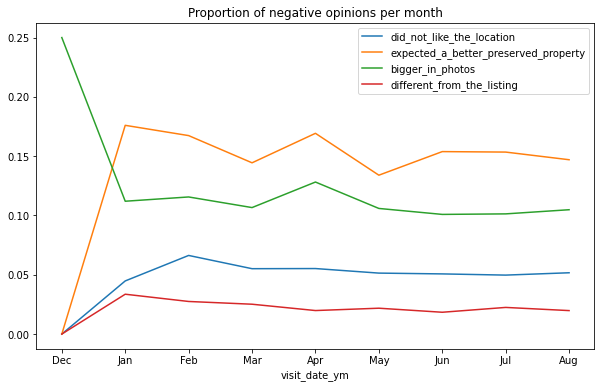

In [71]:
# negative opinions per month
neg_opn_per_month = dftenant_reviews.groupby('visit_date_ym', sort=False)[neg_flags[:-1]].mean()
neg_opn_per_month.plot(title="Proportion of negative opinions per month")
plt.savefig('images/fig06.png')

In [15]:
# alguma review negativa?
dftenant_reviews['sum_neg_opn'] = dftenant_reviews[neg_flags[:-1]].sum(axis=1)

dftenant_reviews.groupby('review')[['sum_neg_opn']].agg(['mean','sum', 'count'])

sum_neg_opn            
                             mean   sum count
review                                       
Visita não aconteceu.    0.000303     1  3302
1                        1.340659   488   364
2                        1.233071   783   635
3                        1.064266  1507  1416
4                        0.857073  1757  2050
5                        0.000000     0  5673
VaiNegociar              0.566667    17    30

## Review changes with visit time?

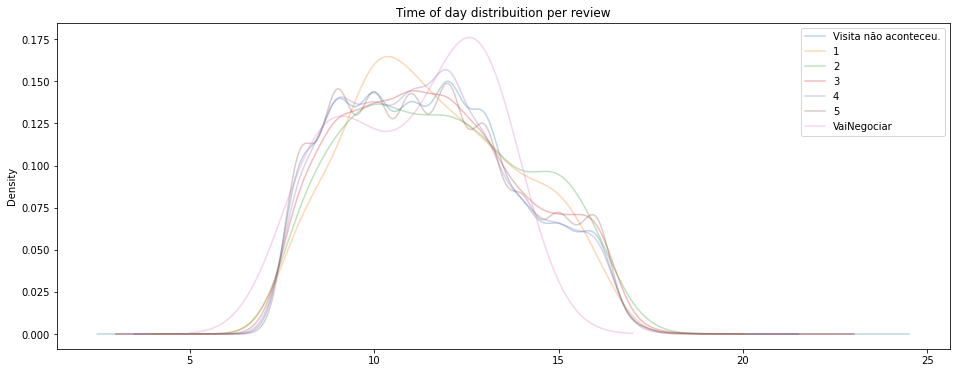

In [16]:
# horario da visita vs review
from datetime import time

#x = pd.Series(range(dftenant_reviews.time.size), index=pd.to_datetime(dftenant_reviews.time).dt.time)


dftenant_reviews['timeh'] = pd.to_datetime(dftenant_reviews.time).pipe(lambda x: x-x.dt.normalize()).astype('timedelta64[h]')

fig, ax = plt.subplots(figsize=(16,6))

dftenant_reviews.groupby('review').timeh.plot.kde(alpha=0.3, ax=ax, title='Time of day distribuition per review')

ax.legend()
plt.show()


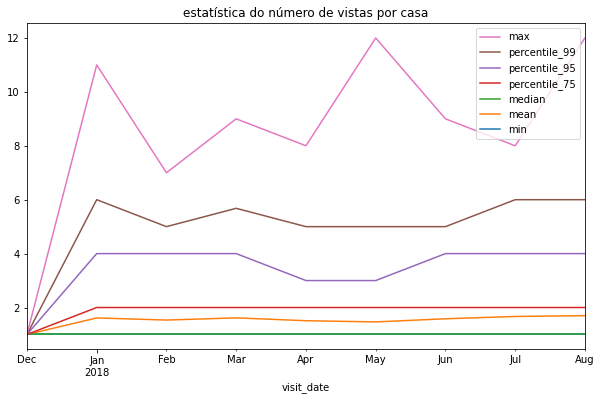

,min,mean,median,percentile_75,percentile_95,percentile_99,max
visit_date,,,,,,,
2017-12-31,1,1.000000,1.0,1.0,1.0,1.00,1
2018-01-31,1,1.612903,1.0,2.0,4.0,6.00,11
2018-02-28,1,1.534739,1.0,2.0,4.0,5.00,7
2018-03-31,1,1.615682,1.0,2.0,4.0,5.68,9
2018-04-30,1,1.510160,1.0,2.0,3.0,5.00,8
2018-05-31,1,1.465753,1.0,2.0,3.0,5.00,12
2018-06-30,1,1.582011,1.0,2.0,4.0,5.00,9
2018-07-31,1,1.668262,1.0,2.0,4.0,6.00,8
2018-08-31,1,1.698630,1.0,2.0,4.0,6.00,12


In [73]:
import numpy as np

def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)

    percentile_.__name__ = "percentile_%s" % n
    return percentile_


# numero médio de visitas por casa
# em média, cada casa foi visitada n vezes por mes
df_visits_per_house = (
    dftenant_reviews.groupby([month, "house_id"])[["total"]]
    .sum()
    .reset_index()
    .groupby("visit_date")
    .total.agg(["min", "mean", "median", percentile(75), percentile(95), percentile(99), "max",])# "count", "var", "std"])
    #.set_index('count', append=True)
)



df_visits_per_house.plot(title='estatística do número de vistas por casa',legend='reverse')
plt.show()

display(df_visits_per_house)

# **3. ideias: analisar/entender o que faz as pessoas voltarem para outras visitas?**
# como aumentar o numero de casas e a qualidade das casas